# Illusion Diffusion

**Explanation of the code:**

- **Import libraries:**
    - `torch`: This library provides extensive capabilities for tensor operations, deep learning modeling, and GPU acceleration. It's essential for building and running neural networks in Python.

- **Device setup:**
    - The code checks for available devices and prioritizes the most suitable one for computations:
        - If a GPU with CUDA support is available, it sets the device to `cuda` to leverage GPU acceleration for faster processing.
        - If a TPU with MPS support is available, it sets the device to `mps` to utilize the **Metal** AI accelerator.
        - If neither CUDA nor MPS devices are found, it defaults to the CPU for computations.
    - The code also prints a message if neither CUDA nor MPS devices are available, indicating that the less-optimal CPU will be used.

- **Device testing:**
    - The `print("Testing torch device")` line serves as a visual confirmation that the device setup process has been completed.
    - The `torch.ones(2, device=device)` line creates a small tensor of ones on the selected device, effectively testing its functionality and ensuring that torch operations can be performed on the chosen hardware.


In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    print ("CUDA & MPS devices not found.")

print("Testing torch device")
torch.ones(2, device=device) 

Testing torch device


tensor([1., 1.], device='mps:0')

# **Explanation of the code:**

**1. Installation and imports:**

- `!pip install diffusers transformers scipy accelerate`: Installs required libraries for text-to-image generation and numerical computations.
- `from diffusers import ...`: Imports necessary classes for working with Stable Diffusion models and pipelines.

**2. Base model selection:**

- `BASE_MODELS = [...]`: Defines a list of potential base diffusion models to choose from.

**3. Loading pre-trained components:**

- `vae = AutoencoderKL.from_pretrained(...)`: Loads a pre-trained Variational Autoencoder (VAE) for encoding and decoding images.
- `controlnet = ControlNetModel.from_pretrained(...)`: Loads a pre-trained control network for guiding image generation.

**4. Pipeline setup:**

- `pipeline = StableDiffusionControlNetPipeline.from_pretrained(...)`: Instantiates a Stable Diffusion pipeline with the chosen base model, VAE, control network, and other configurations.
- `pipeline.to(device)`: Moves the pipeline to the selected device (GPU, TPU, or CPU) for computations.

**5. Filtering components:**

- `image_pipe_components = {...}`: Creates a dictionary with pipeline components, excluding the `image_encoder`.
- `image_pipe = StableDiffusionControlNetImg2ImgPipeline(...)`: Reconstructs the pipeline without the `image_encoder`.

**6. Sampler configuration:**

- `SAMPLER_MAP = {...}`: Defines a mapping between sampler names and their creation functions.
- `sampler = "DPM++ Karras SDE"`: Selects the DPM++ Karras SDE sampler for image generation.
- `pipeline.scheduler = SAMPLER_MAP[sampler](pipeline.scheduler.config)`: Sets the pipeline's scheduler to the chosen sampler.

**7. Random seed:**

- `my_seed = random.randint(...)`: Generates a random seed for reproducibility.
- `generator = torch.Generator(device=device).manual_seed(my_seed)`: Creates a torch generator with the specified seed for controlling randomness in model operations.


In [3]:
# !pip install diffusers transformers scipy accelerate
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, AutoencoderKL, StableDiffusionControlNetImg2ImgPipeline, DPMSolverMultistepScheduler, EulerDiscreteScheduler

BASE_MODELS = [
    "SG161222/Realistic_Vision_V5.1_noVAE",
    "runwayml/stable-diffusion-v1-5"
]

# pre-trained vae
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)

# pre-trained controlnet
controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster", torch_dtype=torch.float16)

# Load the pipeline and move it to the TPU
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODELS[0],
    controlnet=controlnet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float16
).to(device)

image_pipe_components = {k: v for k, v in pipeline.components.items() if k != 'image_encoder'}

image_pipe = StableDiffusionControlNetImg2ImgPipeline(**image_pipe_components)
image_pipe = image_pipe.to(device)

# Sampler map
SAMPLER_MAP = {
    "DPM++ Karras SDE": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True, algorithm_type="sde-dpmsolver++"),
    "Euler": lambda config: EulerDiscreteScheduler.from_config(config),
}

sampler = "Euler"

pipeline.scheduler = SAMPLER_MAP[sampler](pipeline.scheduler.config)
# my_seed = random.randint(0, 2**32 - 1)
generator = torch.Generator(device=device)

/Users/captain2mac/Documents/Code/HuggingFace/ml_env/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/captain2mac/Documents/Code/HuggingFace/ml_env/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/captain2mac/Documents/Code/HuggingFace/ml_env/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/captain2mac/Documents/Code/HuggingFace/ml_env/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


# **Explanation of the code:**

**1. Import necessary libraries:**

- `import requests`: This library enables fetching data from URLs, including images.
- `from PIL import Image`: The Python Imaging Library (PIL) provides tools for working with images, such as opening, manipulating, and saving them.
- `from io import BytesIO`: This class creates in-memory binary streams, useful for handling raw image data.

**2. Specify image URL:**

- `url = 'https://i.ibb.co/6Fgtyw0/IMG-7742.jpg'`: This line stores the web address of the image to be retrieved.

**3. Fetch image data:**

- `response = requests.get(url)`: This sends a GET request to the specified URL and stores the response object in the `response` variable. The response contains the raw image data.

**4. Load image into PIL:**

- `image = Image.open(BytesIO(response.content))`: This line performs the following:
    - `BytesIO(response.content)` creates a BytesIO object, acting as a file-like object, to hold the image data from the response content.
    - `Image.open` opens the image from the BytesIO object, effectively loading it into memory using PIL.
    - The resulting `image` variable now holds a PIL Image object representing the image.


In [4]:
import requests
from PIL import Image
from io import BytesIO

# loading from url
# url = 'https://i.ibb.co/6Fgtyw0/IMG-7742.jpg'
# response = requests.get(url)
# image = Image.open(BytesIO(response.content))

# local image
image = Image.open("input/patterns/pattern_19-27-45.png")

# **Explanation of the code:**

**1. Function `center_crop_resize()`:**

- **Purpose:** Crops an image to its center square and then resizes it to a specified output size.
- **Steps:**
    1. Retrieves the width and height of the input image.
    2. Calculates dimensions to crop the image to a square centered within it.
    3. Performs the cropping using PIL's `crop` method.
    4. Resizes the cropped image to the desired output size using PIL's `resize` method.
    5. Returns the resized image.

**2. Function `common_upscale()`:**

- **Purpose:** Upscales a batch of images using a specified method, with optional cropping.
- **Steps:**
    1. Handles cropping if requested:
        - Calculates dimensions for center cropping based on aspect ratios.
        - Crops the images if necessary.
    2. Applies torch's `nn.functional.interpolate` to upscale the images (either cropped or original).
    3. Returns the upscaled images.

**3. Function `upscale()`:**

- **Purpose:** Upscales a batch of images using a specified method and scale factor.
- **Steps:**
    1. Calculates the target width and height based on the scale factor.
    2. Calls `common_upscale()` to perform the upscaling without cropping.
    3. Returns the upscaled images.


In [5]:
def center_crop_resize(img, output_size=(512, 512)):
    width, height = img.size

    # Calculate dimensions to crop to the center
    new_dimension = min(width, height)
    left = (width - new_dimension)/2
    top = (height - new_dimension)/2
    right = (width + new_dimension)/2
    bottom = (height + new_dimension)/2

    # Crop and resize
    img = img.crop((left, top, right, bottom))
    img = img.resize(output_size)

    return img

def common_upscale(samples, width, height, upscale_method, crop=False):
        if crop == "center":
            old_width = samples.shape[3]
            old_height = samples.shape[2]
            old_aspect = old_width / old_height
            new_aspect = width / height
            x = 0
            y = 0
            if old_aspect > new_aspect:
                x = round((old_width - old_width * (new_aspect / old_aspect)) / 2)
            elif old_aspect < new_aspect:
                y = round((old_height - old_height * (old_aspect / new_aspect)) / 2)
            s = samples[:,:,y:old_height-y,x:old_width-x]
        else:
            s = samples

        return torch.nn.functional.interpolate(s, size=(height, width), mode=upscale_method)

def upscale(samples, upscale_method, scale_by):
        #s = samples.copy()
        width = round(samples["images"].shape[3] * scale_by)
        height = round(samples["images"].shape[2] * scale_by)
        s = common_upscale(samples["images"], width, height, upscale_method, "disabled")
        return (s)

# **Explanation of the code:**

**1. Prompt and control image preparation:**

- **`prompt = "A house between a lake surrounded by trees"`**: Sets the text prompt to guide the image generation process.
- **`control_image_small = center_crop_resize(image)`**: Creates a smaller, center-cropped version of the input image for initial guidance.
- **`control_image_large = center_crop_resize(image, (1024, 1024))`**: Creates a larger, center-cropped version of the input image for later control.

**2. Initial latent generation:**

- **`output = pipeline(...)`**: Uses the Stable Diffusion pipeline to create initial latents based on the prompt and small control image:
    - `prompt`: Provides the text prompt for guidance.
    - `image`: Specifies the small control image.
    - `num_inference_steps=15`: Sets the number of diffusion steps for latent generation.
    - `generator`: Uses the specified random generator for consistent results.
    - `output_type="latent"`: Requests latents as the output.

**3. Latent upscaling:**

- **`upscaled_latents = upscale(output, "nearest-exact", 2)`**: Upscales the initial latents using the `nearest-exact` method and a scaling factor of 2, aiming for higher resolution.

**4. Final image generation:**

- **`out_image = image_pipe(...)`**: Generates the final image using the upscaled latents and large control image:
    - `prompt`: Re-provides the text prompt for consistency.
    - `image`: Provides the upscaled latents as the base.
    - `control_image`: Uses the large control image for more detailed guidance.
    - `negative_prompt="low quality"`: Discourages the generation of low-quality images.
    - `generator`: Continues using the same random generator.
    - `num_inference_steps=20`: Sets the number of diffusion steps for image generation.


In [6]:
prompt = "A house between a lake surrounded by trees"

control_image_small = center_crop_resize(image)
control_image_large = center_crop_resize(image, (1024, 1024))

output = pipeline(
    prompt=prompt,
    image=control_image_small,
    num_inference_steps=15,
    generator=generator,
    output_type="latent"
)

upscaled_latents = upscale(output, "nearest-exact", 2)

out_image = image_pipe(
    prompt=prompt,
    image=upscaled_latents,
    control_image=control_image_large,
    negative_prompt="low quality",
    generator=generator,
    num_inference_steps=20
)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

# **Explanation of the code:**

**1. Importing datetime library:**

- `from datetime import datetime`: This line imports the `datetime` library, which provides functionalities for working with dates and times.

**2. Getting current time:**

- `now = datetime.now()`: This line creates a `datetime` object representing the current date and time.

**3. Formatting time string:**

- `current_time = now.strftime("%H-%M-%S")`: This line formats the current time as a string in the format "HH-MM-SS" (hours-minutes-seconds), storing it in the `current_time` variable.

**4. Saving the generated image:**

- `out_image.images[0].save(f"outputs/output_{current_time}.png")`: This line performs the following:
    - `out_image.images[0]`: Accesses the first generated image from the output of the image generation pipeline.
    - `save(f"outputs/output_{current_time}.png")`: Saves the image to a file with the following structure:
        - Filename: `output_` + (current time string) + `.png`
        - Directory: `outputs/` (assuming this directory exists)


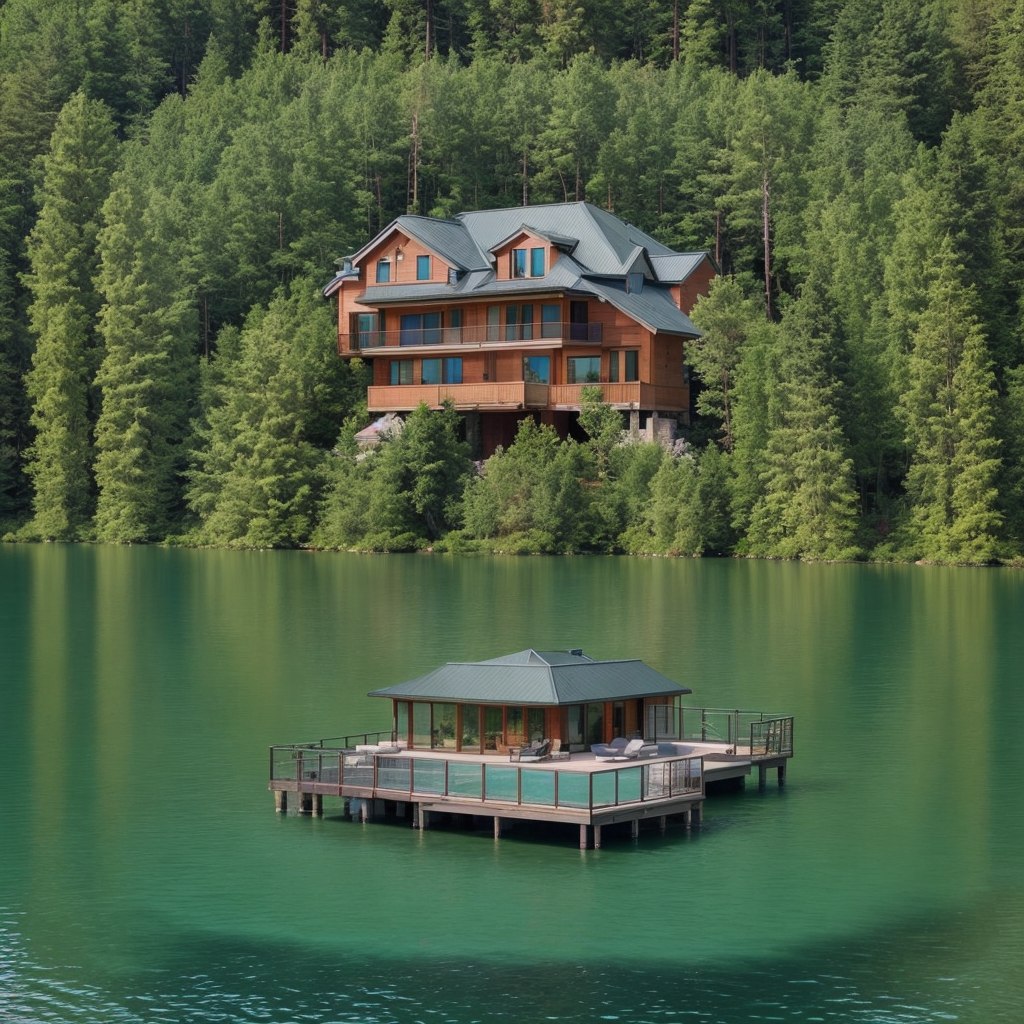

In [7]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H-%M-%S")
image = out_image.images[0]
image.save(f"outputs/output_{current_time}.png")
image